In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
np.random.seed(132)
from functools import lru_cache

import sys

CODE_PATH = '../code'

sys.path.append(CODE_PATH)
import functions


from sklearn.datasets import load_iris, load_boston, load_breast_cancer, load_wine, load_digits
from scipy.optimize import minimize
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


бостон - градиент уходит в 0  
ирис - спустя пару итераций в 0

In [3]:
# dataset = load_breast_cancer()
dataset = load_digits()
df = pd.DataFrame(dataset['data'])
target = dataset['target']
# df = (df - df.mean())/(df.max() - df.min())
# df0 = df.copy()
print(df.shape)
print(target)
df.head()

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.values, target, test_size=0.33, random_state=42)

(1797, 64)
[0 1 2 ... 8 9 8]


# Формируем дихотомическую матрицу

In [4]:
# num_classes
l = np.unique(target).size
N = 15

In [5]:
# формируем дих матрицу l*N
code_matrix = np.zeros((l, N))
def add_random_dich(l=10, code_matrix=None):
    if code_matrix is None:
        # матрица пуста
        dich = np.random.randint(0, 2, l)
        while np.unique(dich).size == 1:
            dich = np.random.randint(0, 2, l)
        return dich.reshape((-1, 1))
    # матрица непуста
    dich = np.random.randint(0, 2, l)
    def does_dich_exist(dich, code_matrix):
        diff = (cm == dich).sum(axis=0)
        if diff.max() == l or diff.min() == 0:
            return True
        return False
    while np.unique(dich).size == 1 and not does_dich_exist(dich, code_matrix):
        dich = np.random.randint(0, 2, l)
#     print(code_matrix.shape, dich.shape)
    return np.hstack([code_matrix, dich.reshape((-1, 1))])

In [6]:
code_matrix = None
for i in tqdm(range(N), desc='Adding dich'):
    code_matrix = add_random_dich(l, code_matrix)

Adding dich: 100%|██████████| 15/15 [00:00<00:00, 12178.58it/s]


In [7]:
code_matrix

array([[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]])

# Обучаем классификаторы

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

BaseClassifier = LogisticRegression
dich_classifiers = []
for i in tqdm(range(N), desc='Training dich classifiers'):
    clf = BaseClassifier()
    X = X_train
    y_classes = code_matrix.T[i]
    y = np.array([y_classes[i] for i in y_train])
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    y_true = np.array([y_classes[i] for i in y_test])
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    dich_classifiers.append({'model': clf, 'accuracy': accuracy, 'f1': f1})

Training dich classifiers: 100%|██████████| 15/15 [00:00<00:00, 24.32it/s]


In [11]:
dich_classifiers

[{'accuracy': 0.9158249158249159,
  'f1': 0.8903508771929824,
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)},
 {'accuracy': 0.9107744107744108,
  'f1': 0.7836734693877552,
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)},
 {'accuracy': 0.9494949494949495,
  'f1': 0.9638554216867469,
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
     

In [9]:
def predict_codeword(x, dich_classifiers):
    codeword = []
    for dich in dich_classifiers:
        clf = dich['model']
        codeword.append(clf.predict(x.reshape(1, -1)))
    return np.array(codeword).flatten()

def hamming(arr1, arr2, scores=None):
    if scores is None:
        return (arr1 != arr2).sum()
    return ((arr1 != arr2)*scores).sum() + ((arr1 == arr2)*(1-scores)).sum()
    
def predict_class(x, dich_classifiers, code_matrix, use_scores=False, verbose=False):
    codeword = predict_codeword(x, dich_classifiers)
    if not use_scores:
        hammings = np.array([hamming(codeword, class_code) for class_code in code_matrix])
    else:
        scores = np.array([d['score'] for d in dich_classifiers])
        hammings = np.array([hamming(codeword, class_code, scores) for class_code in code_matrix])
    if verbose:
        print(hammings)
    indices = np.where(hammings == hammings.min())
    return np.random.choice(indices[0])

In [10]:
preds = [predict_class(x, dich_classifiers, code_matrix, True) for x in X_test]
from sklearn.metrics import accuracy_score
accuracy_score(preds, y_test)

0.8737373737373737

#  Оптимизация
Создаем вектор x1, ... , xN, y (размер N+1)  
Далее https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html

In [11]:
c = np.zeros(N+1)
c[-1] = -1

In [12]:
# размер A Nx (l*(l-1)/2)
A_ub = []
b_ub = np.zeros(l*(l-1)//2)

for nu in range(l):
    for mu in range(nu+1, l):
        A_arr = []
        for j in range(N):
            A_arr.append(-np.abs(code_matrix[nu][j] - code_matrix[mu][j]))
        A_arr.append(1)
        A_ub.append(A_arr)
        
A_ub = np.array(A_ub)
A_ub = np.vstack([A_ub, -np.eye(N+1)[:-1]]) # x_i >= 0
b_ub = np.append(b_ub, np.zeros(N))
# or
# bounds = np.zeros((N+1, 2))
# bounds[:,0] = None
# bounds[-1] = None
# bounds

In [13]:
A_eq = np.ones(N+1).reshape((1, -1))
A_eq[0][-1] = 0
b_eq = np.array(N).reshape((-1))
A_eq, b_eq

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]]),
 array([15]))

In [14]:
from scipy.optimize import linprog
opt_result = linprog(c, A_ub, b_ub, A_eq, b_eq, options={'disp': True})

Optimization terminated successfully.
         Current function value: -5.454545   
         Iterations: 14


In [15]:
opt_result['x']

array([1.36363636, 0.        , 0.        , 2.72727273, 1.36363636,
       1.36363636, 0.        , 0.        , 0.        , 1.36363636,
       1.36363636, 2.72727273, 1.36363636, 1.36363636, 0.        ,
       5.45454545])


# Конструируем модельную задачу

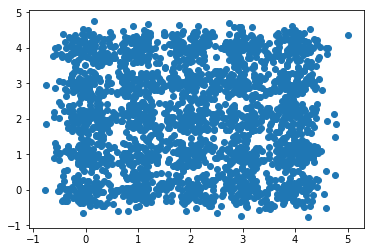

In [13]:
np.random.seed(100)
cluster_objects = 100
num_clusters = 5

mean = np.zeros(2)
cov = np.eye(2) * 0.07
X = []

y = np.zeros(num_clusters**2*cluster_objects)

for i in np.linspace(0, num_clusters-1, num_clusters):
    for j in np.linspace(0, num_clusters-1, num_clusters):
        mean = np.array([i, j])
        X_cluster = np.random.multivariate_normal(mean, cov, cluster_objects)
        X.append(X_cluster)
X = np.vstack(X)
scatter(X[:,0], X[:,1], )

In [15]:
# объединяем классы
classes_in_cluster = 5

order = np.array(range(num_clusters**2))
np.random.shuffle(order)
splits = np.split(order, 5)
for i, split in enumerate(splits):
    for item in split:
        y[item*cluster_objects:(item+1)*cluster_objects] = i

[ 4.  4.  4. ...,  3.  3.  3.]


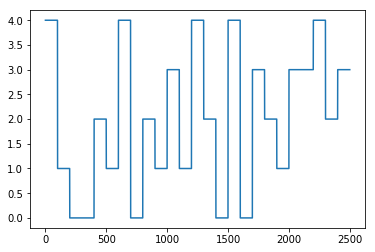

In [16]:
print(y)
plot(y)

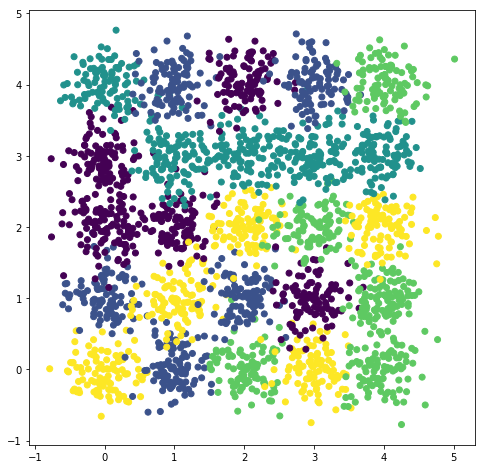

In [24]:
figsize(8, 8)
scatter(X[:,0], X[:,1], c=y, )

5

[11, 2, 8, 9, 10, 6, 3, 10, 1, 10, 8, 2, 2, 4, 6, 5, 0, 11, 11, 1]


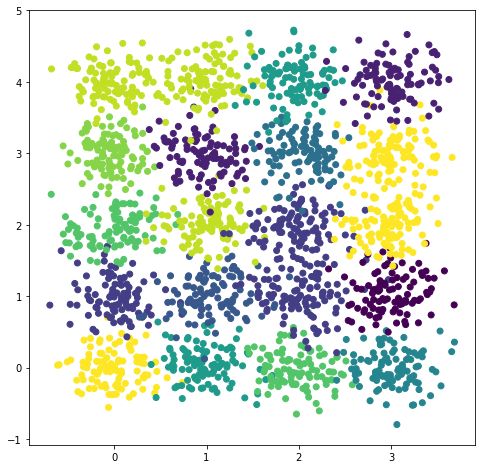

In [46]:
# модельная задача на 12 классов
colors = []
cs = []

# np.random.seed(100)
cluster_objects = 100
num_clusters = 5

mean = np.zeros(2)
cov = np.eye(2) * 0.07
X = []

y = np.zeros(num_clusters**2*cluster_objects)

for i in np.linspace(0, 4-1, 4):
    for j in np.linspace(0, 5-1, 5):
        c = np.random.randint(0, 12)
        mean = np.array([i, j])
        X_cluster = np.random.multivariate_normal(mean, cov, cluster_objects)
        X.append(X_cluster)
        colors += [c]*cluster_objects
        cs.append(c)
X = np.vstack(X)
print(cs)
scatter(X[:,0], X[:,1], c=colors)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

# Load a multi-label dataset
yeast = fetch_mldata('yeast')
X = yeast['data']
Y = yeast['target'].transpose().toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,
                                                    random_state=0)

In [57]:
yeast['target']

1.0

In [84]:
df = pd.read_csv('../yeast.data.txt', sep=';', header=None)
X = df.values[:,1:-1]
y = pd.factorize(df[9])[0]
y

array([0, 0, 0, ..., 5, 1, 2])

In [89]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1484 samples in 0.002s...
[t-SNE] Computed neighbors for 1484 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1484
[t-SNE] Computed conditional probabilities for sample 1484 / 1484
[t-SNE] Mean sigma: 0.068286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.533401
[t-SNE] Error after 300 iterations: 1.245500


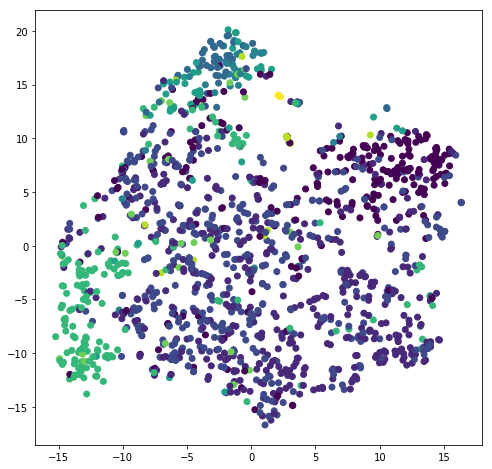

In [91]:
scatter(tsne_results[:,0], tsne_results[:,1], c=y)
